# VOCODER ANALYSIS

## Authors:
#### * Cortada Garcia, Martí
#### * Gadea Alcaide, Tomàs
#### * Matas Albiol, Pau
#### * Poch Soler, Jofre

### Setup:

In [1]:
# numerical
import scipy.io
import scipy.signal
import numpy as np
# plotting
import matplotlib.pyplot as plt
%matplotlib notebook
# sound modules
import sounddevice as sd
from scipy.io import wavfile
# warnings
import warnings
warnings.filterwarnings('ignore')  # shut warnings

### Auxiliar functions:

In [2]:
def rescale(signal, factor=6, interpolate=False):
    dom = len(signal)
    if not interpolate:
        new = np.zeros(dom*factor)
        for idx, val in enumerate(signal):
            new[idx*factor] = val
        return new
    # with interpolation:
    return np.interp(np.linspace(0, dom, factor*dom+1), np.arange(dom), signal)

### Loading files:

In [3]:
mat = scipy.io.loadmat('sintesis.mat')  # dict
# delete useless data
del mat['__header__']
del mat['__version__']
del mat['__globals__']
print(mat.keys())

dict_keys(['coef', 'excit', 'ganancia'])


In [4]:
B = mat['ganancia'][0]
a_i = mat['coef']
x_n = mat['excit']

print("B   (type, shape) = ", type(B), B.shape)
print("a_i (type, shape) = ", type(a_i), a_i.shape)
print("x_n (type, shape) = ", type(x_n), x_n.shape)

B   (type, shape) =  <class 'numpy.ndarray'> (401,)
a_i (type, shape) =  <class 'numpy.ndarray'> (401, 11)
x_n (type, shape) =  <class 'numpy.ndarray'> (401, 120)


### Brief introduction:

Before getting into the subject, let us explain briefly how the synthetic signal is generated and how we will us it. The signal is generated as follows:
$$y[n]=bx[n]-\sum_{i=1}^{p}a_iy[n-1]\hspace{1cm}n=0,...,N-1$$
where:
* $b=$ gainth 
* $x[n]=$ excitation ($x[n]=excit[n]$)
* $coef[i]=a[i];$   $i=0,...,p;$   $a[0=1]$

and we keep concatenating each $y[n]$-plot till we get the total synthetic signal. Once understood the mathematical aprroximation, we will take advantadge of $\texttt{python}$ and use **scipy.signal.lfilter(** _b, a, x, axis=- 1, zi=None_ **)** which modelizes the previous approximation directly.

# SECTION A: Filtering 

## Part A

We are asked to represent the impulse response of the 100-plot. To do so, we will put at the input of the filter the sequence $x[n]={1, 0, 0, 0, 0, ...}$ Afterwards, we will study its lenght:

<IPython.core.display.Javascript object>


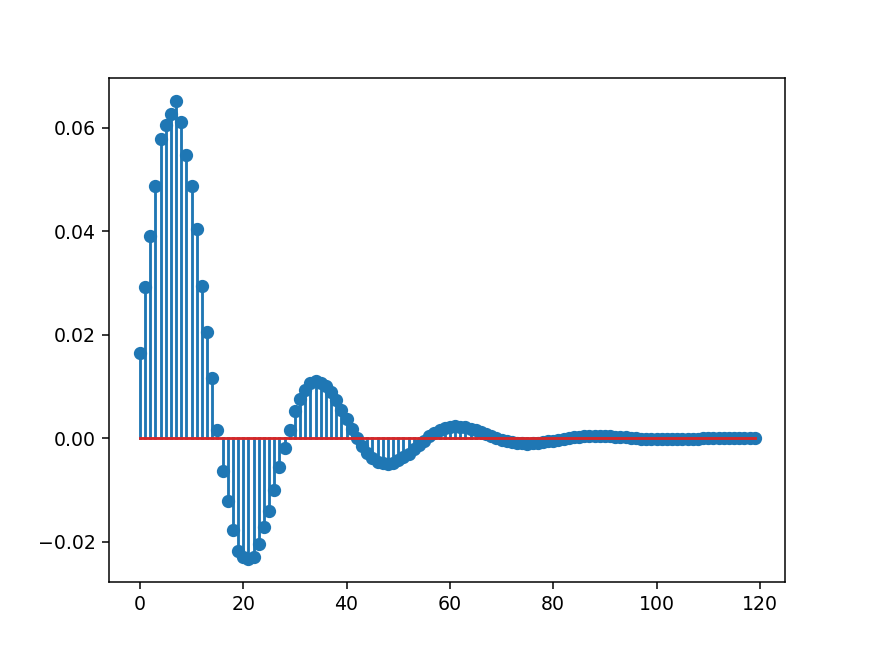

<StemContainer object of 3 artists>

In [7]:
dK = np.array([1]+[0]*119)  # Kronecker delta
h_n = scipy.signal.lfilter([B[99]], a_i[99], dK, axis= -1, zi=None)  # impulse response 
plt.close('all')
plt.stem(range(120), h_n)

In [8]:
print(len(h_n))

120


### Conclusion part A:
The impulse response has length 120.

## Part B

We will represent the same output (that is the 100-plot), but now we are asked to apply its corresponding excitement and gainth (that we can find at _sintesis.mat_ file, which we previously load). Let's see the output:

<IPython.core.display.Javascript object>


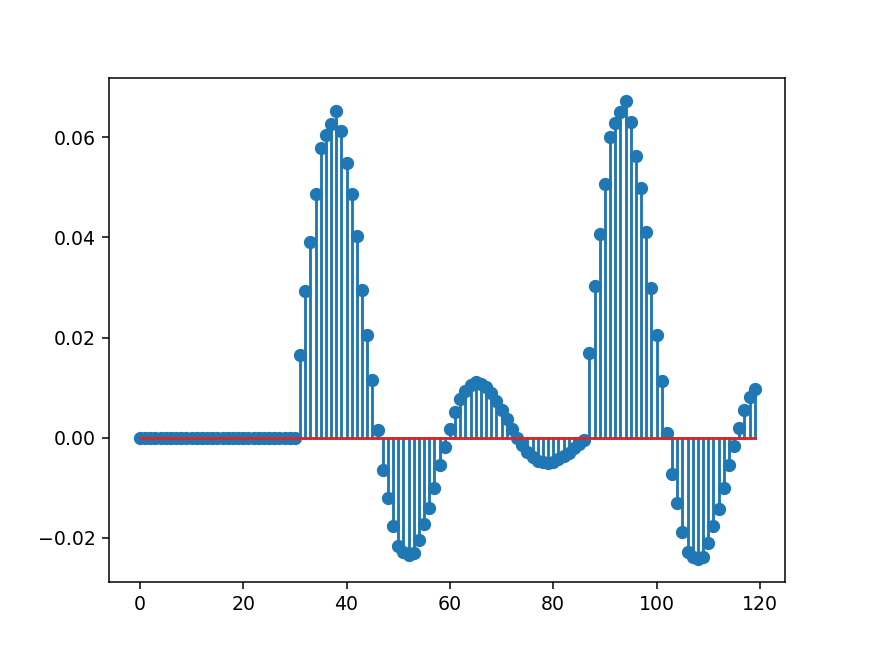

<StemContainer object of 3 artists>

In [9]:
y_n = scipy.signal.lfilter([B[99]], a_i[99], x_n[99], axis= -1, zi=None)
plt.close('all')
plt.stem(range(120), y_n)

## Part C

Finally, we will compute the total synthesis filtring all plots with its corresponding excitations and concatenating the outputs. Let's check what happens:

<IPython.core.display.Javascript object>


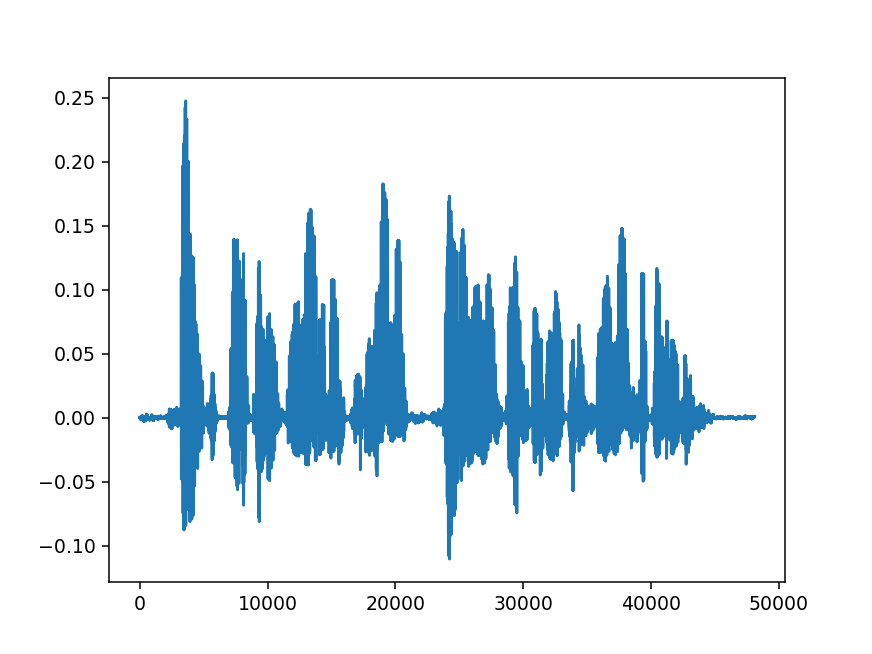

In [10]:
domain = range(120*401)
output = np.array([])
for n in range(401):
    output = np.append(output, scipy.signal.lfilter([B[n]], a_i[n], x_n[n], axis= -1, zi=None))

plt.close('all')
plt.plot(domain, output)

In [11]:
sd.play(output)

PortAudioError: Error querying device -1

The output signal is quite short to be heard propperly, thus let output be rescaled for the sake of practicality:

In [12]:
output_r = rescale(output)
sd.play(output_r)

PortAudioError: Error querying device -1

## Part D

In [158]:
idxs = np.argwhere(output==0)
print("There are ", len(idxs), " points where output is zero")
first_zero =  idxs[0,0]
print("The first index where output is zero: ", first_zero)

There are  4927  points where output is zero
The first index where output is zero:  3360


<IPython.core.display.Javascript object>


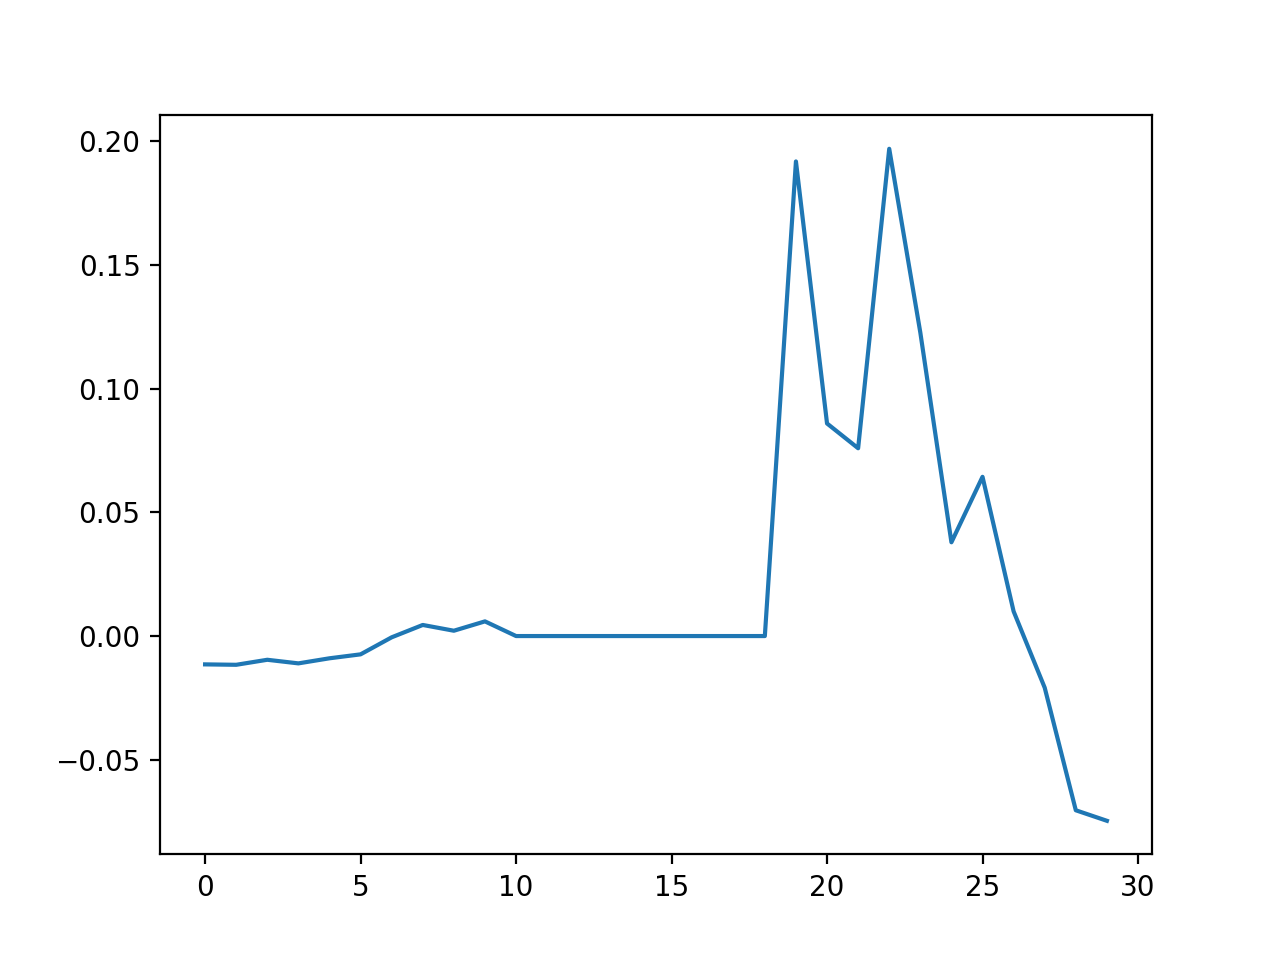

In [159]:
plt.close('all')
plt.plot(range(30), output[first_zero - 10:first_zero+20])

### Conclusion Part D:
In this example we can see that there is a secuence where the output is zero, and suddenly it changes to a higher value. If we do this for every zero secuence we can see the changes in the signal

## Part E

In [160]:
output2 = np.array([])
zf = np.zeros(10)
for n in range(401):
    evaluate, zf = scipy.signal.lfilter([B[n]], a_i[n], x_n[n], axis= -1, zi=zf[-10:])
    output2 = np.append(output2, evaluate)

<IPython.core.display.Javascript object>


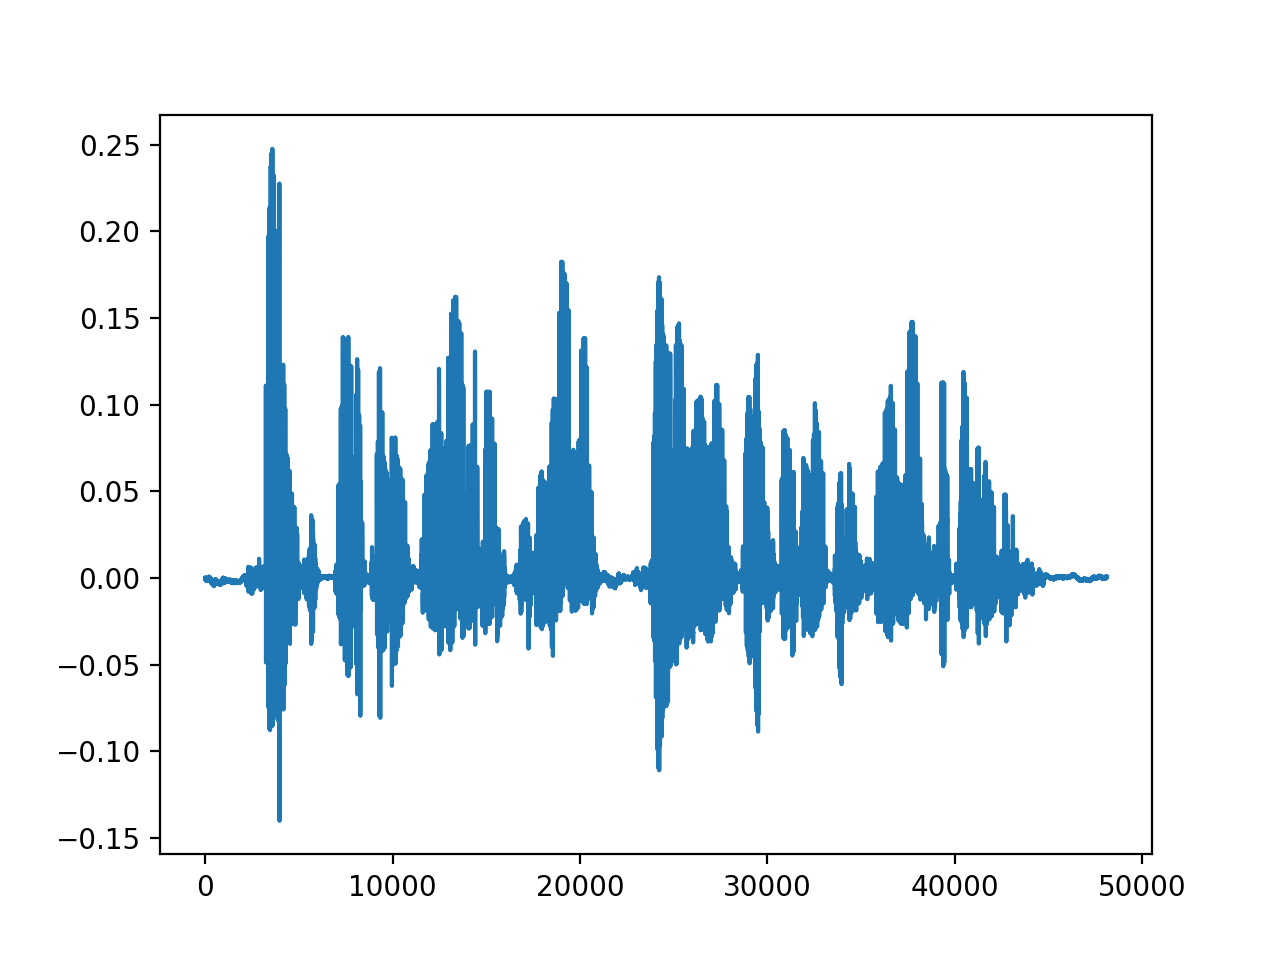

In [161]:
plt.close('all')
plt.plot(range(120*401), output2)

In [162]:
idxs = np.argwhere(output2==0)
print(len(idxs))

0


### Conclusion Part E:
It is shown by the last cell of code that there are 0 indexes where the signal is zero.

## Part F

Again, let output2 be rescaled:

In [163]:
output2_r = rescale(output2, interpolate=True)

In [165]:
sd.play(output_r)

In [166]:
sd.play(output2_r)

### Conclusion Part F
The first signal is of a such lower quality than the second one. This is because the output2 signal has been fedback with itself, and the union of the phonems is smoother. Therefore it sounds more clear.

# SECTION B: Excitation estimation

# SECTION C: Synthetic signal modification